In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from datetime import datetime
from dateutil.relativedelta import relativedelta as rd

In [2]:
ini = datetime.now()

In [3]:
from tensorflow.python.client import device_lib

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9039283890295552128,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4325310464
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1407398587855253559
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"]

#### Carga y preparación de datos

In [5]:
bld = tfds.builder('mnist')
bld.download_and_prepare()
ds = bld.as_dataset(shuffle_files=False)
dstro = ds['train']
dsteo = ds['test']

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
TAM_BUFF = 10000
TAM_LOTE = 64
NUM_EP = 40

In [8]:
dstr = dstro.map(lambda item:(tf.cast(item['image'],tf.float32)/255.0,tf.cast(item['label'],tf.int32)))
dste = dsteo.map(lambda item:(tf.cast(item['image'],tf.float32)/255.0,tf.cast(item['label'],tf.int32)))

In [9]:
tf.random.set_seed(0)
dstr = dstr.shuffle(buffer_size=TAM_BUFF,reshuffle_each_iteration=False)
dsva = dstr.take(10000).batch(TAM_LOTE)
dstr = dstr.skip(10000).batch(TAM_LOTE)

#### Construcción de la CNN

In [10]:
"""
Arquitectura 
28x28x1-->Conv(5x5x32)-->28x28x32-->Pooling(2x2)-->14x14x32-->
Conv(5x5x64)-->14x14x64-->Pooling(2x2)-->7x7x64-->Flat-->1024-->
FC1-->FC2-->10
"""

cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(5,5),
                               strides=(1,1),
                               padding='same',
                               data_format='channels_last',
                               name='conv1',
                               activation='relu'
                              ))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                  name='pool1'
                                 ))

cnn.add(tf.keras.layers.Conv2D(filters=64,
                               kernel_size=(5,5),
                               strides=(1,1),
                               padding='same',
                               data_format='channels_last',
                               name='conv2',
                               activation='relu'
                              ))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                  name='pool2'
                                 ))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=1024,
                              name='fc1',
                              activation='relu'
                             ))

cnn.add(tf.keras.layers.Dropout(rate=0.5
                               ))

cnn.add(tf.keras.layers.Dense(units=10,
                              name='fc2',
                              activation='softmax'
                             ))

In [11]:
tf.random.set_seed(0)
cnn.build(input_shape=(None,28,28,1))

In [12]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        51264     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              3212288   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

#### Entrenamiento del Modelo

In [13]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
           )

In [14]:
historia = cnn.fit(dstr,
                   epochs=NUM_EP,
                   validation_data=dsva,
                   shuffle=True)

Epoch 1/40
782/782 [==============================] - 7s 5ms/step - loss: 0.1398 - accuracy: 0.9553 - val_loss: 0.0439 - val_accuracy: 0.9867
Epoch 2/40
782/782 [==============================] - 4s 5ms/step - loss: 0.0431 - accuracy: 0.9863 - val_loss: 0.0365 - val_accuracy: 0.9888
Epoch 3/40
782/782 [==============================] - 4s 5ms/step - loss: 0.0303 - accuracy: 0.9899 - val_loss: 0.0363 - val_accuracy: 0.9897
Epoch 4/40
782/782 [==============================] - 4s 5ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.0412 - val_accuracy: 0.9881
Epoch 5/40
782/782 [==============================] - 4s 5ms/step - loss: 0.0171 - accuracy: 0.9941 - val_loss: 0.0421 - val_accuracy: 0.9898
Epoch 6/40
782/782 [==============================] - 4s 5ms/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 0.0395 - val_accuracy: 0.9891
Epoch 7/40
782/782 [==============================] - 4s 5ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.0428 - val_accuracy: 0.9904
Epoch 

#### Resultados

In [15]:
import matplotlib.pyplot as plt
import numpy as np

hist = historia.history
x_arr = np.arange(len(hist['loss']))+1

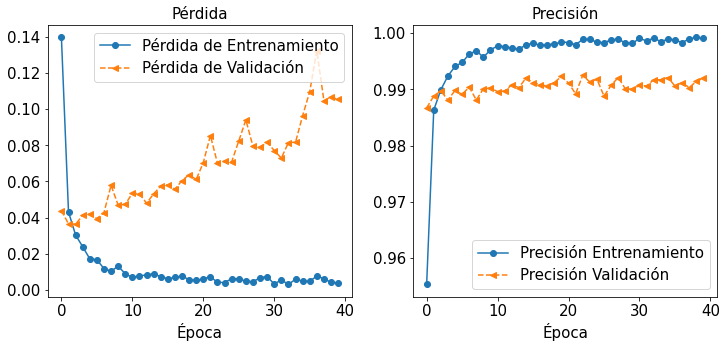

In [16]:

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(hist['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],'-o',label='Precisión Entrenamiento')
ax.plot(hist['val_accuracy'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()

In [18]:
resultados_prueba = cnn.evaluate(dste.batch(200))
print('Precisión Prueba %.4f'%resultados_prueba[1])

50/50 [==============================] - 0s 4ms/step - loss: 0.0720 - accuracy: 0.9922
Precisión Prueba 0.9922


tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


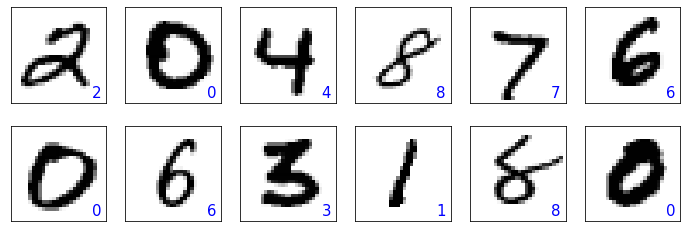

In [19]:
lote_prueba = next(iter(dste.batch(12)))
pred = cnn(lote_prueba[0])

pred = tf.argmax(pred,axis=1)
print(pred)
fig = plt.figure(figsize=(12,4))
for i in range(12):
    ax = fig.add_subplot(2,6,i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = lote_prueba[0][i,:,:,0]
    ax.imshow(img,cmap='gray_r')
    ax.text (0.9,0.1,'{}'.format(pred[i]),
             size=15,
             color='blue',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)
plt.show()

In [20]:
rd(datetime.now(),ini)

relativedelta(minutes=+30, seconds=+4, microseconds=+536317)